In [1]:
import pandas as pd
from name_matching.name_matcher import NameMatcher
import unicodedata
from transliterate import translit
from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
df = pd.read_csv('../data/train.csv')
df

,pair_id,name_1,name_2,is_duplicate
0,1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
1,2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
2,3,"Rishichem Distributors Pvt., Ltd.",Dsa,0
3,4,Powermax Rubber Factory,Co. One,0
4,5,Tress A/S,Longyou Industries Park Zhejiang,0
...,...,...,...,...
497814,497815,BIT-MAT PRODUCTS,The Goodyear Tire and Rubber Company,0
497815,497816,"Bnd Trading Co., Ltd.",Zhong Shan Yue Liang Economy& Trade Imp. & Exp...,0
497816,497817,"Xeikon Industrial Co., Ltd. Of Dongguan City","Yi Cheng Trading Co., Ltd. Of Dongguan City",0
497817,497818,"Shanghai Kechuan Trading Co., Ltd.",Shanghai M&G Stationery Inc.,0


In [3]:
df.drop('pair_id', axis=1, inplace=True)

In [4]:
df.dtypes

name_1          object
name_2          object
is_duplicate     int64
dtype: object

In [5]:
df['is_duplicate'].value_counts(), df['is_duplicate'].value_counts(normalize=True)

(0    494161
 1      3658
 Name: is_duplicate, dtype: int64,
 0    0.992652
 1    0.007348
 Name: is_duplicate, dtype: float64)

In [6]:
df.isnull().sum()

name_1          0
name_2          0
is_duplicate    0
dtype: int64

### Preprocess

In [8]:
df_new = df.copy()

In [9]:
df_new['name_1'] = df_new['name_1'].apply(lambda text: str(text.lower()))
df_new['name_2'] = df_new['name_2'].apply(lambda text: str(text.lower()))

In [10]:
df_new.head()

,name_1,name_2,is_duplicate
0,iko industries ltd.,"enormous industrial trade pvt., ltd.",0
1,apcotex industries ltd.,technocraft industries (india) ltd.,0
2,"rishichem distributors pvt., ltd.",dsa,0
3,powermax rubber factory,co. one,0
4,tress a/s,longyou industries park zhejiang,0


In [11]:
df_new['name_1']  = df_new['name_1'].apply(
    lambda text: unicodedata.normalize('NFKD', text)
)

df_new['name_2']  = df_new['name_2'].apply(
    lambda text: unicodedata.normalize('NFKD', text)
)

df_new

,name_1,name_2,is_duplicate
0,iko industries ltd.,"enormous industrial trade pvt., ltd.",0
1,apcotex industries ltd.,technocraft industries (india) ltd.,0
2,"rishichem distributors pvt., ltd.",dsa,0
3,powermax rubber factory,co. one,0
4,tress a/s,longyou industries park zhejiang,0
...,...,...,...
497814,bit-mat products,the goodyear tire and rubber company,0
497815,"bnd trading co., ltd.",zhong shan yue liang economy& trade imp. & exp...,0
497816,"xeikon industrial co., ltd. of dongguan city","yi cheng trading co., ltd. of dongguan city",0
497817,"shanghai kechuan trading co., ltd.",shanghai m&g stationery inc.,0


In [58]:
df_new.isnull().sum()

name_1          0
name_2          0
is_duplicate    0
dtype: int64

In [12]:
df_all_cmp = pd.concat(
    [
        df_new[['name_1']].rename(columns={'name_1': 'company'}),
        df_new[['name_2']].rename(columns={'name_2': 'company'})
    ],
    ignore_index=True,
)

df_all_cmp

,company
0,iko industries ltd.
1,apcotex industries ltd.
2,"rishichem distributors pvt., ltd."
3,powermax rubber factory
4,tress a/s
...,...
995633,the goodyear tire and rubber company
995634,zhong shan yue liang economy& trade imp. & exp...
995635,"yi cheng trading co., ltd. of dongguan city"
995636,shanghai m&g stationery inc.


In [13]:
df_all_cmp.tail()

,company
995633,the goodyear tire and rubber company
995634,zhong shan yue liang economy& trade imp. & exp...
995635,"yi cheng trading co., ltd. of dongguan city"
995636,shanghai m&g stationery inc.
995637,burlington industries corporate


In [14]:
df_all_cmp.isnull().sum()

company    0
dtype: int64

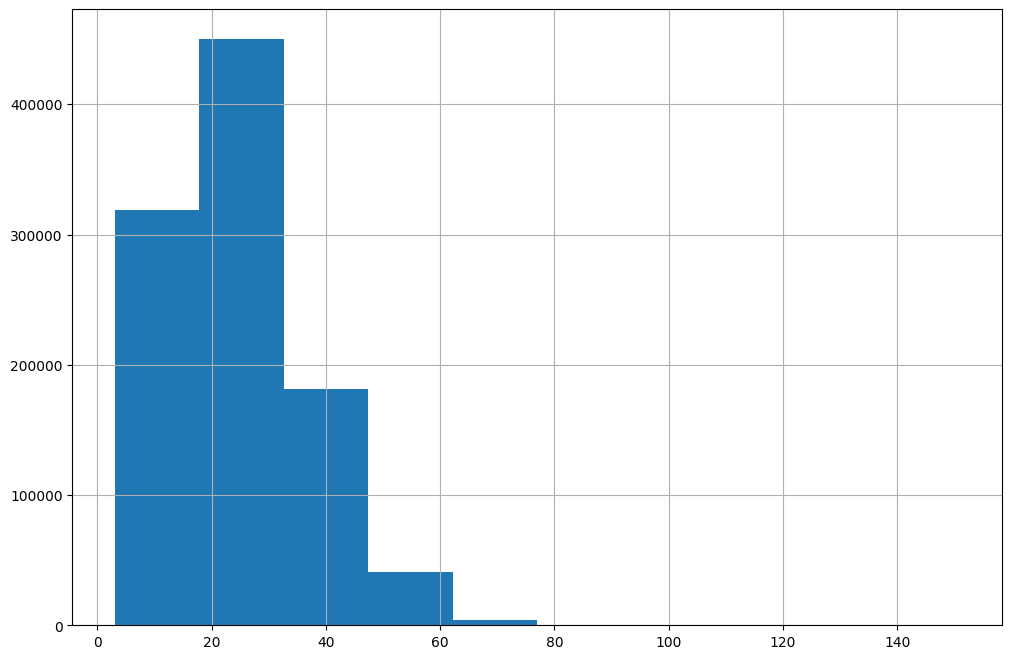

In [15]:
df_all_cmp['length'] = df_all_cmp['company'].apply(lambda text: len(str(text)))
df_all_cmp['length'].hist(figsize=(12,8));

In [16]:
print(f"median: {df_all_cmp['length'].median()}\nmean: {df_all_cmp['length'].mean():.3f}\nmin: {df_all_cmp['length'].min()}\nmax: {df_all_cmp['length'].max()}")

median: 23.0
mean: 24.138
min: 3
max: 151


In [17]:
df_all_cmp[df_all_cmp['length'] == 3]

,company,length
45,dsi,3
133,cts,3
247,dsi,3
291,dsi,3
322,mcl,3
...,...,...
995343,ibm,3
995360,ilg,3
995377,m.b,3
995509,dsi,3


In [18]:
def translit_company_on_lat(df: pd.DataFrame, col_name_1: str = 'name_1', col_name_2: str = 'name_2') -> None:
    for col in [col_name_1, col_name_2]:
        translit_cmp = list()
        for company in tqdm(df[col]):
            try:
                translit_cmp.append(translit(company, reversed=True))
            except:
                translit_cmp.append(company)
        df[col] = translit_cmp

In [19]:
translit_company_on_lat(df_new)
df_new

  0%|          | 0/497819 [00:00<?, ?it/s]

  0%|          | 0/497819 [00:00<?, ?it/s]

,name_1,name_2,is_duplicate
0,iko industries ltd.,"enormous industrial trade pvt., ltd.",0
1,apcotex industries ltd.,technocraft industries (india) ltd.,0
2,"rishichem distributors pvt., ltd.",dsa,0
3,powermax rubber factory,co. one,0
4,tress a/s,longyou industries park zhejiang,0
...,...,...,...
497814,bit-mat products,the goodyear tire and rubber company,0
497815,"bnd trading co., ltd.",zhong shan yue liang economy& trade imp. & exp...,0
497816,"xeikon industrial co., ltd. of dongguan city","yi cheng trading co., ltd. of dongguan city",0
497817,"shanghai kechuan trading co., ltd.",shanghai m&g stationery inc.,0


In [20]:
df_new.iloc[43399]

name_1          goodyear 
name_2             repsol
is_duplicate            0
Name: 43399, dtype: object

In [21]:
df_new.to_csv('../data/preprocess_train.csv', index=False)

### Add new raw in data

In [3]:
df = pd.read_csv('../data/preprocess_train.csv')
df.head()

,name_1,name_2,is_duplicate
0,iko industries ltd.,"enormous industrial trade pvt., ltd.",0
1,apcotex industries ltd.,technocraft industries (india) ltd.,0
2,"rishichem distributors pvt., ltd.",dsa,0
3,powermax rubber factory,co. one,0
4,tress a/s,longyou industries park zhejiang,0


In [5]:
df_true = df[df['is_duplicate']==1]

In [16]:
df_true['name_1'].value_counts()

soprema sa                                                                                           39
bridgestone india pvt ltd                                                                            34
bridgestone ncr                                                                                      34
bridgestone tire co                                                                                  34
bridgestone india                                                                                    34
                                                                                                     ..
ooovertikal sport                                                                                     1
deboer schoten                                                                                        1
celanese operations mexico s de rl de cv                                                              1
zeon kasei changshu coltd                                       

In [20]:
df_true.reset_index(drop=True, inplace=True)

In [50]:
matcher = NameMatcher(top_n=100,
    lowercase=True,
    punctuations=True,
    remove_ascii=True,
    legal_suffixes=False,
    common_words=False,
    verbose=True)

matcher.set_distance_metrics(['discounted_levenshtein',
                              'SSK',
                              'fuzzy_wuzzy_token_sort'])

In [51]:
matcher.load_and_process_master_data('name_2', df_true)
df_result = matcher.match_names(
    to_be_matched=pd.DataFrame({'name_1': ['soprema sa']}), 
    column_matching='name_1'
)

/home/mlandrey/PycharmProjects/ITMO/Name-matcher/.venv/lib/python3.8/site-packages/name_matching/name_matcher.py:663: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, column_name] = df[column_name].astype(str)
/home/mlandrey/PycharmProjects/ITMO/Name-matcher/.venv/lib/python3.8/site-packages/name_matching/name_matcher.py:665: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, column_name] = df[column_name].str.lower()
/home/mlandrey/PycharmProjects/ITMO/Name-matcher/.venv/lib/python3.8/site-pack

preprocessing...

preprocessing complete 
 searching for matches...



100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1389.76it/s]


possible matches found   
 fuzzy matching...



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.62it/s]

done


In [52]:
df_true.iloc[0]

name_1                  jx nippon oil gas exploration brasil ltda
name_2          jx nippon oil gas exploration technical servic...
is_duplicate                                                    1
Name: 0, dtype: object

In [53]:
df_result

,original_name,match_name,score,match_index
0,soprema sa,soprema sa,100.0,199.0


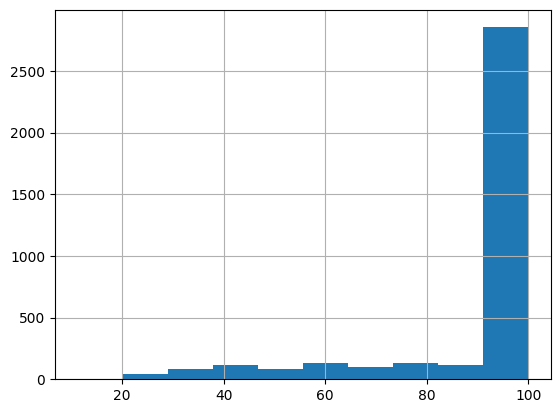

In [36]:
df_result['score'].hist();

In [37]:
df_result[df_result['score'] > 60]

,original_name,match_name,score,match_index
0,jx nippon oil gas exploration brasil ltda,jx nippon oil gas exploration brasil ltda,100.0,868.0
1,pirelli neumaticos saic,pirelli neumaticos saic,100.0,110.0
2,brenntag australia pty ltd,brenntag australia pty ltd,100.0,584.0
3,paul bauder gmbh co kg bochum plant,paul bauder gmbh co kg bochum plant,100.0,1721.0
4,total ceska republika sro,total ceska republika sro,100.0,853.0
...,...,...,...,...
3652,bridgestone stargard sp zoo,bridgestone stargard sp zoo,100.0,46.0
3653,bridgestone huizhousynthetic rubber co ltd,bridgestone huizhousynthetic rubber co ltd,100.0,22.0
3655,brenntag peru sac,brenntag peru sac,100.0,47.0
3656,dow chemical international private ltd,dow chemical international private ltd,100.0,353.0


In [30]:
df_true.iloc[3655]

name_1                                   brenntag peru sac
name_2          brenntag chile comercial e industrial ltda
is_duplicate                                             1
Name: 3655, dtype: object

In [31]:
df_true.iloc[484]

name_1          brenntag chile comercial e ind
name_2                 brenntag vietnam co ltd
is_duplicate                                 1
Name: 484, dtype: object

### NLTK

In [57]:
from nltk.tokenize import word_tokenize

In [58]:
df_new = df.copy()

In [65]:
df_result = df.copy()
df_result['data'] = 'original'
df_result.head()

,name_1,name_2,is_duplicate,data
0,iko industries ltd.,"enormous industrial trade pvt., ltd.",0,original
1,apcotex industries ltd.,technocraft industries (india) ltd.,0,original
2,"rishichem distributors pvt., ltd.",dsa,0,original
3,powermax rubber factory,co. one,0,original
4,tress a/s,longyou industries park zhejiang,0,original


In [60]:
df_new['n1_first_word'] = [word_tokenize(comp)[0] for comp in df_new['name_1']]
df_new['n2_first_word'] = [word_tokenize(comp)[0] for comp in df_new['name_2']]
df_new

,name_1,name_2,is_duplicate,n1_first_word,n2_first_word
0,iko industries ltd.,"enormous industrial trade pvt., ltd.",0,iko,enormous
1,apcotex industries ltd.,technocraft industries (india) ltd.,0,apcotex,technocraft
2,"rishichem distributors pvt., ltd.",dsa,0,rishichem,dsa
3,powermax rubber factory,co. one,0,powermax,co.
4,tress a/s,longyou industries park zhejiang,0,tress,longyou
...,...,...,...,...,...
497814,bit-mat products,the goodyear tire and rubber company,0,bit-mat,the
497815,"bnd trading co., ltd.",zhong shan yue liang economy& trade imp. & exp...,0,bnd,zhong
497816,"xeikon industrial co., ltd. of dongguan city","yi cheng trading co., ltd. of dongguan city",0,xeikon,yi
497817,"shanghai kechuan trading co., ltd.",shanghai m&g stationery inc.,0,shanghai,shanghai


In [62]:
df_new[df_new['n1_first_word']=='bnd']

,name_1,name_2,is_duplicate,n1_first_word,n2_first_word
11004,"bnd trading co., ltd.",taraki s.a.s.,0,bnd,taraki
13345,"bnd trading co., ltd.",al misbah al jadeed trading llc,0,bnd,al
18884,"bnd trading co., ltd.",hangers trading sociedad anonima cerrada,0,bnd,hangers
33347,"bnd trading co., ltd.",impy exp. rehman trading ltda,0,bnd,impy
35442,"bnd trading co., ltd.",jmk international goodstrading center,0,bnd,jmk
...,...,...,...,...,...
487527,"bnd trading co., ltd.","kisco trading india pvt., ltd.",0,bnd,kisco
493871,"bnd trading co., ltd.",eazy trading inc.,0,bnd,eazy
493962,"bnd trading co., ltd.","crystal (shanghai) international trading co., ...",0,bnd,crystal
496164,"bnd trading co., ltd.",shoe palace trading,0,bnd,shoe


In [67]:
for idx in tqdm(range(df_new.shape[0])):
    n1_word, n2_word = df_new['n1_first_word'].iloc[idx], df_new['n2_first_word'].iloc[idx]
    df_curr = df_new.drop(index=idx)
    
    df_curr_n11 = df_curr[df_curr['n1_first_word'] == n1_word]
    df_curr_n11 = df_curr_n11[df_curr_n11['name_1'] != df_new['name_1'].iloc[idx]]
    df_result = pd.concat(
        [            
            df_result,
            pd.DataFrame(
                {
                    'name_1': [df_new['name_1'].iloc[idx] for _ in range(df_curr_n11.shape[0])],
                    'name_2': df_curr_n11['name_1'].tolist(),
                    'is_duplicate': [1 for _ in range(df_curr_n11.shape[0])],
                    'data': ['n11' for _ in range(df_curr_n11.shape[0])]
                }
            )
        ]
    )
    
    df_curr_n12 = df_curr[df_curr['n2_first_word'] == n1_word]
    df_curr_n12 = df_curr_n12[df_curr_n12['name_2'] != df_new['name_1'].iloc[idx]]
    df_result = pd.concat(
        [            
            df_result,
            pd.DataFrame(
                {
                    'name_1': [df_new['name_1'].iloc[idx] for _ in range(df_curr_n12.shape[0])],
                    'name_2': df_curr_n12['name_2'].tolist(),
                    'is_duplicate': [1 for _ in range(df_curr_n12.shape[0])],
                    'data': ['n12' for _ in range(df_curr_n12.shape[0])]
                }
            )
        ]
    )
        
        
    df_curr_n21 = df_curr[df_curr['n1_first_word'] == n2_word]
    df_curr_n21 = df_curr_n21[df_curr_n21['name_1'] != df_new['name_2'].iloc[idx]]
    df_result = pd.concat(
        [            
            df_result,
            pd.DataFrame(
                {
                    'name_1': df_curr_n21['name_1'].tolist(),
                    'name_2': [df_new['name_2'].iloc[idx] for _ in range(df_curr_n21.shape[0])],
                    'is_duplicate': [1 for _ in range(df_curr_n21.shape[0])],
                    'data': ['n21' for _ in range(df_curr_n21.shape[0])]
                }
            )
        ]
    )
    
    
    df_curr_n22 = df_curr[df_curr['n2_first_word'] == n2_word]
    df_curr_n22 = df_curr_n22[df_curr_n22['name_2'] != df_new['name_2'].iloc[idx]]
    df_result = pd.concat(
        [            
            df_result,
            pd.DataFrame(
                {
                    'name_1': df_curr_n22['name_2'].tolist(),
                    'name_2': [df_new['name_2'].iloc[idx] for _ in range(df_curr_n22.shape[0])],
                    'is_duplicate': [1 for _ in range(df_curr_n22.shape[0])],
                    'data': ['n22' for _ in range(df_curr_n22.shape[0])]
                }
            )
        ]
    )    
    
    del df_curr_n11, df_curr_n12, df_curr_n21, df_curr_n22

  0%|          | 0/497819 [00:00<?, ?it/s]

KeyboardInterrupt: 